In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.ndimage.filters import maximum_filter

In [ ]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')
#folder_path = "/content/drive/MyDrive/CSED/Assignments - L4T1/Computer Vision/Assignments - CV/Assignment 1/"
folder_path = "/content/drive/MyDrive/test/"

Mounted at /content/drive


## Part I: Applying Image Processing Filters For Image Cartoonifying

### 0. Read the image in grayscale and show it

Image Shape:  (371, 248)


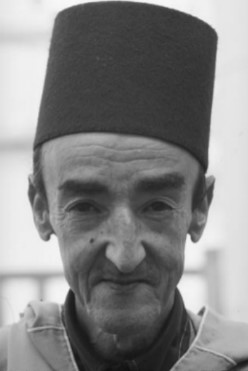

In [ ]:
file_path = folder_path + "9.jpg"
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # 0
print("Image Shape: ", img.shape)
cv2_imshow(img)

### 1. Generating a black-and-white sketch

**Steps:** Noise Reduction Using Median Filter -- Edge Detection Using Laplacian Filter

In [ ]:
# median filter -- good at removing noise while keeping edges sharp
img_blurred = cv2.medianBlur(img, 7)

# laplacian filter -- works only on gray scale
img_laplacian = cv2.Laplacian(img_blurred, -1, ksize=5)

# apply binary threshold -- edge is black or white
_,img_sketch = cv2.threshold(img_laplacian, 127, 255, cv2.THRESH_BINARY_INV)

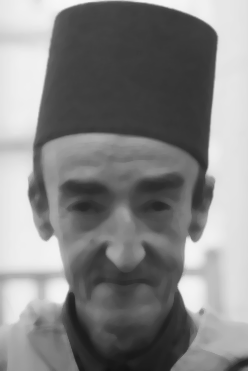

In [ ]:
cv2_imshow(img_blurred)

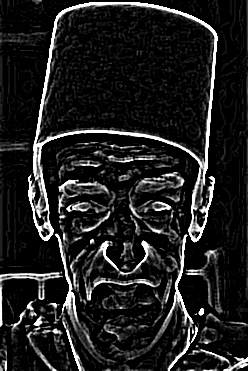

In [ ]:
cv2_imshow(img_laplacian)

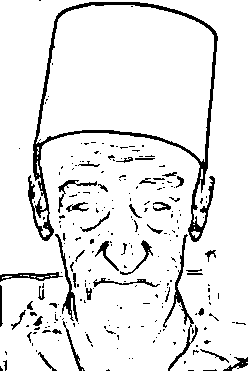

In [ ]:
cv2_imshow(img_sketch)

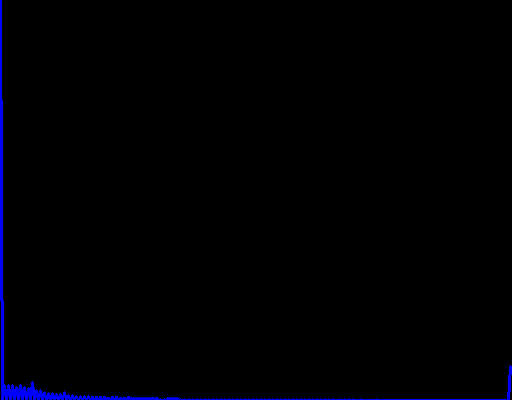

In [ ]:
# Histogram
resized = np.reshape(img_laplacian, (1, img_laplacian.shape[0], img_laplacian.shape[1]))
histSize = 256 # since the number of unique values in the image is 256 value
histRange = (0, 256)
accumulate = False
histogram = cv2.calcHist(resized,[0], None, [histSize], histRange, accumulate=accumulate)

hist_w = 512 
hist_h = 400
bin_w = int(round( hist_w/histSize ))
histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)

cv2.normalize(histogram, histogram, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)

for i in range(1, histSize):
    cv2.line(histImage, ( bin_w*(i-1), hist_h - int(round(histogram[i-1][0])) ),
            ( bin_w*(i), hist_h - int(round(histogram[i][0])) ),
            ( 255, 0, 0), thickness=2)
cv2_imshow(histImage)

### 2. Generating a color painting and a cartoon

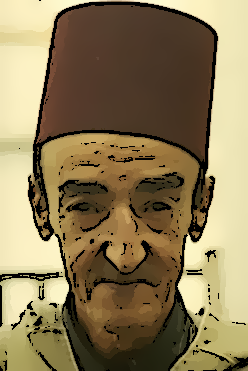

In [ ]:
# apply many small bilateral filters to produce a strong cartoon effect in less time
cartoon = cv2.imread(file_path)

for i in range(15):
  cartoon = cv2.bilateralFilter(cartoon, 9, 8, 9)

edges = img_sketch.copy()
edges = edges / 255.0

final = cartoon.copy()

final[:,:,0] = cartoon[:,:,0] * edges
final[:,:,1] = cartoon[:,:,1] * edges
final[:,:,2] = cartoon[:,:,2] * edges

cv2_imshow(final)

## Part II: Road Lane Detection Using Hough Transform

### Smoothing the image in grayscale

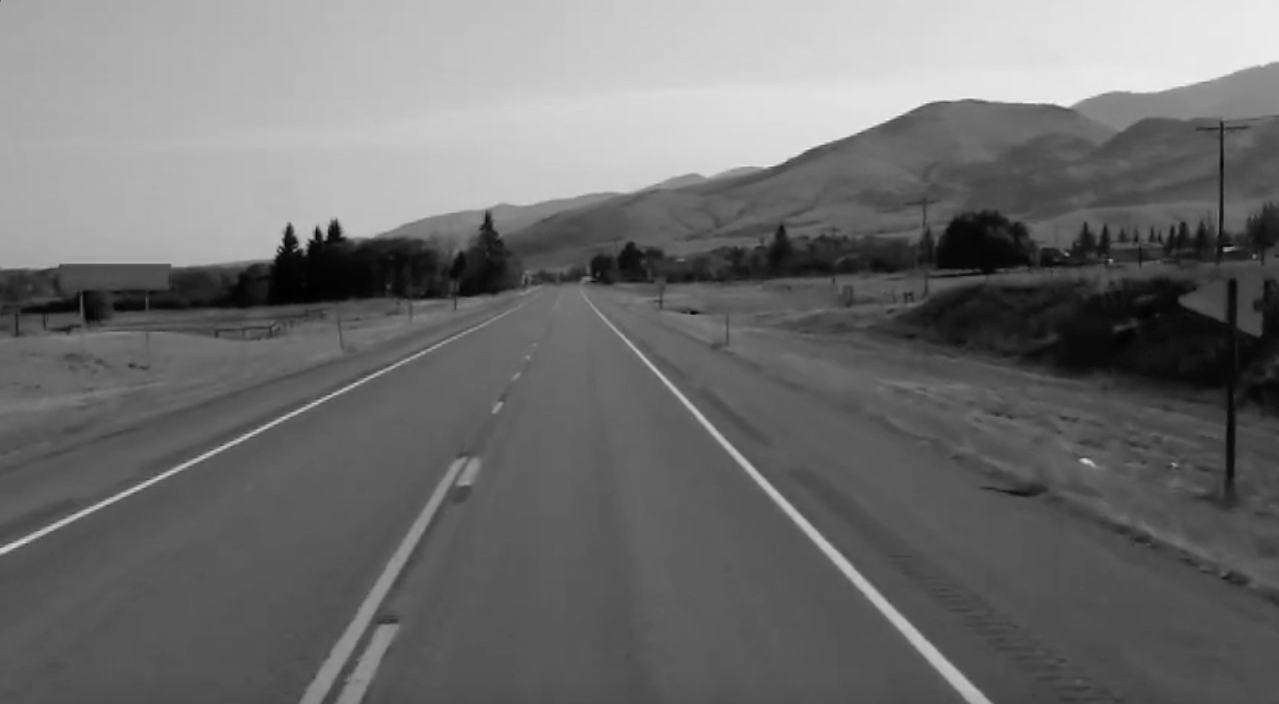

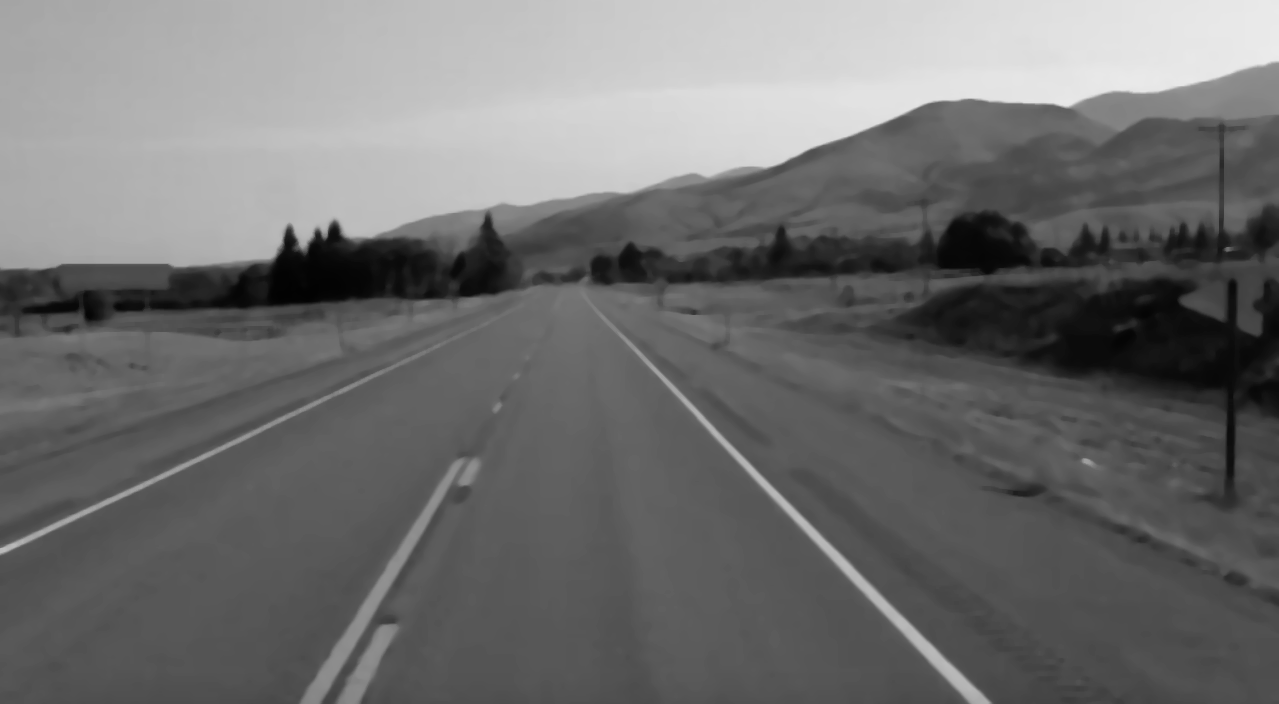

In [ ]:
hough_file_path = folder_path + "testHough.jpg"
hough_img = cv2.imread(hough_file_path, cv2.IMREAD_GRAYSCALE) # 0
cv2_imshow(hough_img)

height = hough_img.shape[0]
width = hough_img.shape[1]
diagonal = int(round(math.sqrt(math.pow(height, 2) + math.pow(width, 2))))

hough_smoothed = cv2.medianBlur(hough_img, 7)
cv2_imshow(hough_smoothed)

### Edge Detection 

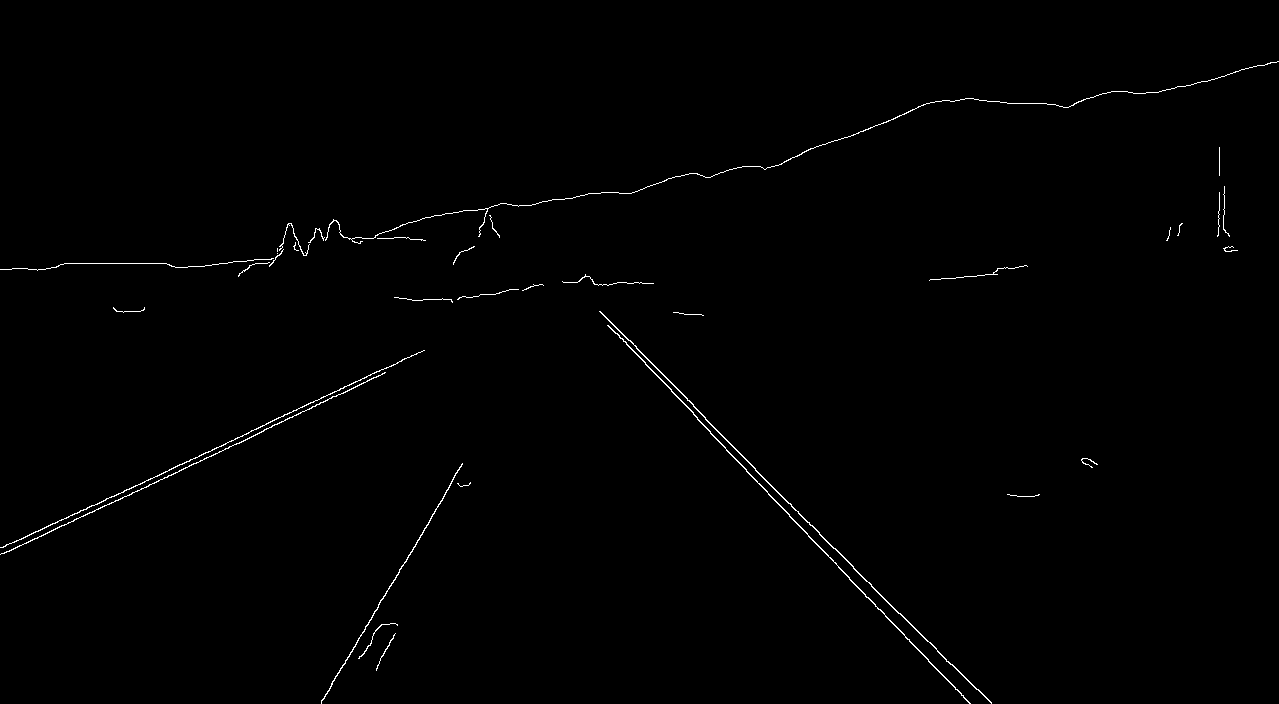

In [ ]:
edges = cv2.Canny(hough_smoothed, 90, 180) 
cv2_imshow(edges)

### Region of Interest 

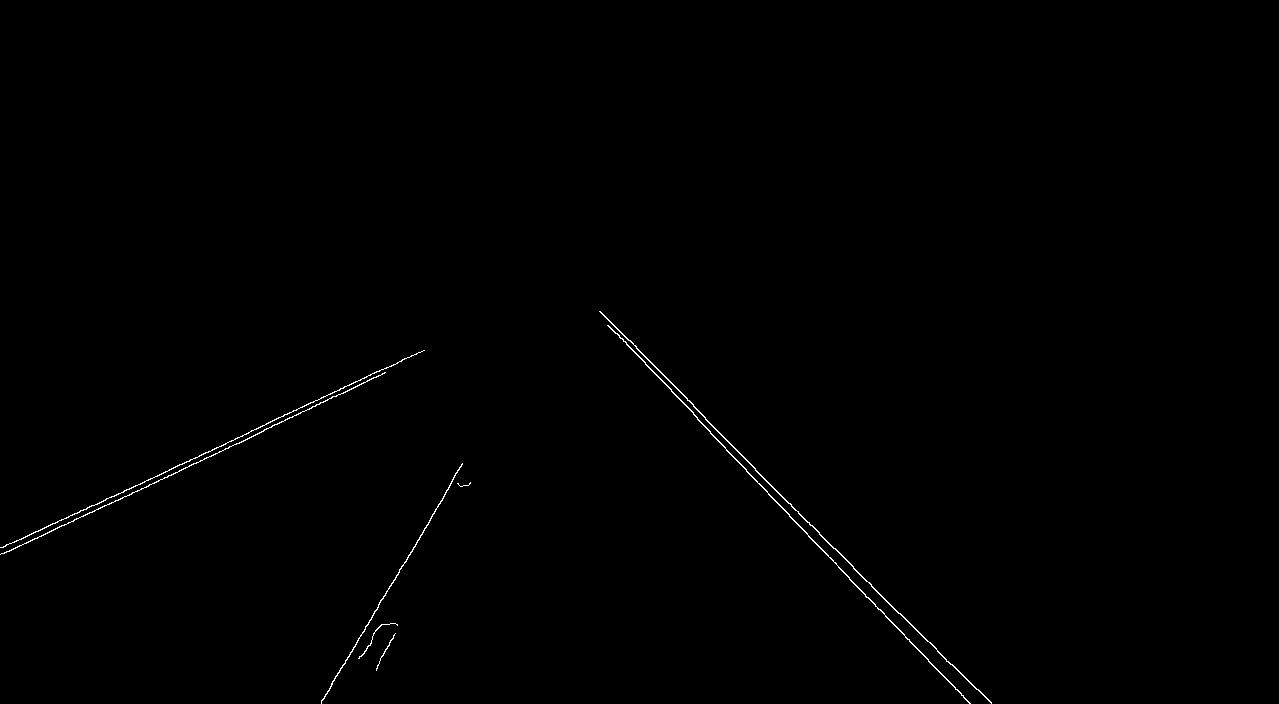

In [ ]:
ROI = edges.copy()
points = np.array([[0, 0], [0, 500], [426, 320],
                   [620, 290], [1040, height],
                   [width, height], [width, 0]])
cv2.fillPoly(ROI, pts=[points], color=(0))
cv2_imshow(ROI)

### Accumulation into (ρ, θ)-space using Hough transform

In [ ]:
H = np.zeros((181, (2*diagonal)+1))
for j in range(width):
  for i in range(height):
    if ROI[i, j] == 255:
      for theta  in range (0, 181):
        p = int((i * math.cos(theta) + j * math.sin(theta)) + diagonal)
        H[theta, p] = H[theta, p] + 1
print(np.unique(H))
print(H)      

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  81.  82.  84.  85.
  86.  88.  90.  91.  92.  93.  94.  96.  97.  98. 100. 101. 102. 103.
 105. 109. 111. 112. 113. 114. 115. 118. 119. 121. 122. 126. 127. 128.
 134. 135. 139. 141. 143. 144. 145. 147. 150. 155. 157. 161. 176. 188.
 198. 204. 215. 221. 230. 240. 262. 282. 285. 294. 297. 298. 342.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Refining Coordinates and HT Post-Processing

In [ ]:
for i in range(181):
  for j in range(2*diagonal + 1):
    if H[i, j] <= 150:
      H[i, j] = 0

out = maximum_filter(H, 433)
unique_vals = np.unique(out)
print(unique_vals)

[  0. 155. 215. 285. 294. 297. 298. 342.]


In [ ]:
theta_p = np.zeros((1,2))
for i in range(181):
  for j in range(2921):
    if H[i,j] in unique_vals and H[i, j] != 0:
      theta_p = np.append(theta_p, [[i, j - 1460]], axis=0)
theta_p = np.delete(theta_p, (0), axis=0)
print(theta_p)

[[  35. -502.]
 [  35. -497.]
 [  67. -638.]
 [  89.  634.]
 [ 106. -221.]
 [ 128.  212.]
 [ 172.  204.]]


In [ ]:
def get_point(rho, theta, x):
  y = (rho-(x*math.cos(theta)))/(math.sin(theta))
  return y  

In [ ]:
img = cv2.imread(hough_file_path)
x1 = 330
x2 = 703

In [ ]:
def draw_line(theta, rho):
  y1 = int(get_point(rho, theta, x1))
  y2 = int(get_point(rho, theta, x2))
  cv2.line(img, (y2,x2), (y1,x1), color=(0, 255, 255), thickness=2)

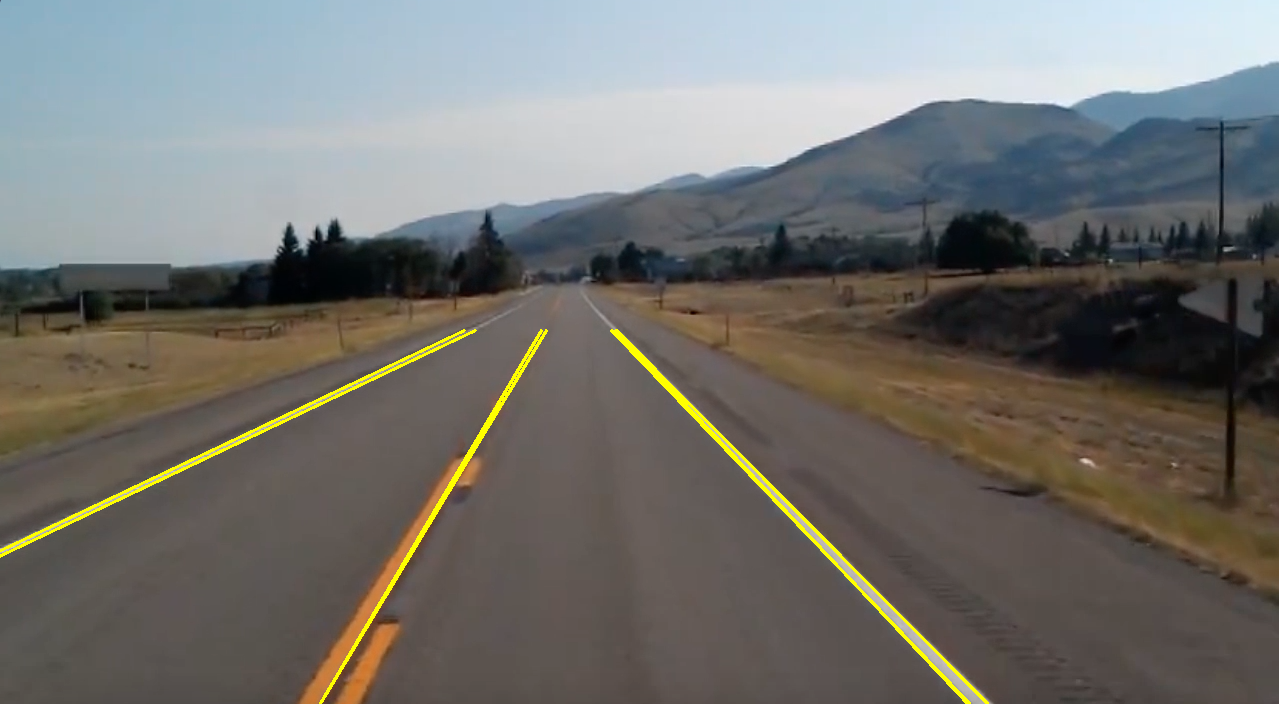

In [ ]:
for row in theta_p:
  draw_line(row[0], row[1])
cv2_imshow(img)